In [ ]:
#Main Script for applying autoencoder based HiTS, AHiTS, LSTM, SINDy scheme for PDEs
### This is a comparative study of various schemes
#Asif Hamid Bhat # 06-04-2023

In [64]:
## clear ram
# import torch
# with torch.no_grad():
#     torch.cuda.empty_cache()
# %reset

### Load libraries

In [2]:
########## imports  ##############
import os
import time
import sys
import numpy as np
import scipy as sp
from scipy import integrate, interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import pickle
from torch.nn.functional import normalize

import warnings
warnings.filterwarnings('ignore')
# Path for various functions
module_path= os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
criterion = torch.nn.MSELoss(reduction='none')
import ResNet as net
from utils import *
from Autoencoder import *

In [3]:
# paths
noise = 0.0 
system = 'KS'  
data_dir = os.path.join('../data/', system)
model_dir = os.path.join('../models/', system)
path_to_result=os.path.join('../results/', system)
path=os.path.join('../aehitsResults/KS/data', system)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'

In [4]:
model_dir

'../models/KS'

#### LOAD DATA

In [5]:
train_data = torch.load(data_dir + "/train_data.pt")
val_dataALL = torch.load(data_dir + "/val_data.pt")
test_dataALL = torch.load(data_dir + "/test_data.pt")
# train_data=train_data.transpose(1, 2)
# train_data=train_data[:,:-1,:]
# val_data=val_data[:,:-1,:]
# test_dataALL=test_dataALL[:,:-1,:]

In [6]:
test_dataALL.shape

torch.Size([5, 51201, 120])

In [7]:
# load data
# train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
# val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
# test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
n_train = train_data.shape[0]
n_val = val_dataALL.shape[0]
n_test = test_dataALL.shape[0]
train_data=torch.tensor(train_data).to(torch.float32)
# train_data = train_data
# sets=train_data.shape[0]
# dataloader=torch.utils.data.DataLoader(x, batch_size=sets)
train_data.shape,test_dataALL.shape,val_dataALL.shape

(torch.Size([200, 5121, 120]),
 torch.Size([5, 51201, 120]),
 torch.Size([5, 51201, 120]))

### define AUTOENCODER model

In [8]:
input_size=test_dataALL.shape[2]
hidden_size=8
L1=120
L2=120
L3=100
modelAE = AE(L1,L2,L3,input_size=input_size, hidden_size=hidden_size).to(device)
# modelAE.train(model1, dataloader, num_epochs=5000, learning_rate=1e-3)

### load autoencoder model

In [9]:
# model_path=model_dir+'/FHNAE_best.pt' ### for fhn NEW
# model_path='../models/FHN/AE_{}.pt'.format(hidden_size) #for FHN
# model_path='../models/KS/AE2_{}_{}.pt'.format(hidden_size,n_train)
model_path='../models/KS/KStest.pt'
model_state_dict = torch.load(model_path)
modelAE.load_state_dict(model_state_dict)

<All keys matched successfully>

In [10]:
T1=train_data.shape[1]
T2=2*T1
T3=3*T1
T4=4*T1
T5=5*T1
T7=7*T1
T10=10*T1

In [11]:
### testing data size
t_test=T1#test_dataALL.shape[1]#T5 #(T1+1),(T10)
test_data=test_dataALL[:,:t_test,:]#.reshape(4,5120,202)
val_data=val_dataALL[:,:t_test,:]#.reshape(4,5120,202)
test_data.shape,val_data.shape,t_test

(torch.Size([5, 5121, 120]), torch.Size([5, 5121, 120]), 5121)

In [12]:
# Generate some random test data
idx=0
test_dataAE = torch.tensor(test_data[:,:,:]).to(torch.float32).to(device)
#test_data=normalize(test_data)
# Encode the test data
encoded = modelAE.encoder(test_dataAE)
# Decode the encoded data
#decoded = modelAE.decoder(encoded)
AEpred= modelAE.decoder(encoded).cpu().detach().numpy()
# AEpred=modelAE(test_dataAE).cpu().detach().numpy()
# AEpred=AEpred.cpu().detach().numpy()
# Print the original and reconstructed data
# print('Original:', test_data)
# print('Reconstructed:', decoded)

test_dataAE=test_dataAE.cpu().detach().numpy()
#t=np.linspace(1,512*6,0.01)
# plt.plot(test_dataAE[idx,:,10],'k',lw=2)
# plt.plot(AEpred[idx,:,10],'r--',lw=2)
# # plt.plot(test_data[:,100:],'k',lw=2)
# # plt.plot(pred[:,100:],'r--',lw=2)
# plt.show()

In [13]:
# z=encoded.cpu().detach().numpy()
# plt.plot(z[0,:,:])
# plt.show()

In [14]:
#fig, (ax1) = plt.subplots(figsize=(50, 20), ncols=1)
#pos = ax1.imshow(cmap='Blues', interpolation='none')
#fig.colorbar(pos, ax=ax1)
#a=ax1.imshow(np.abs(test_data[:,100:].T-pred[:,100:].T))
#fig.colorbar(a)

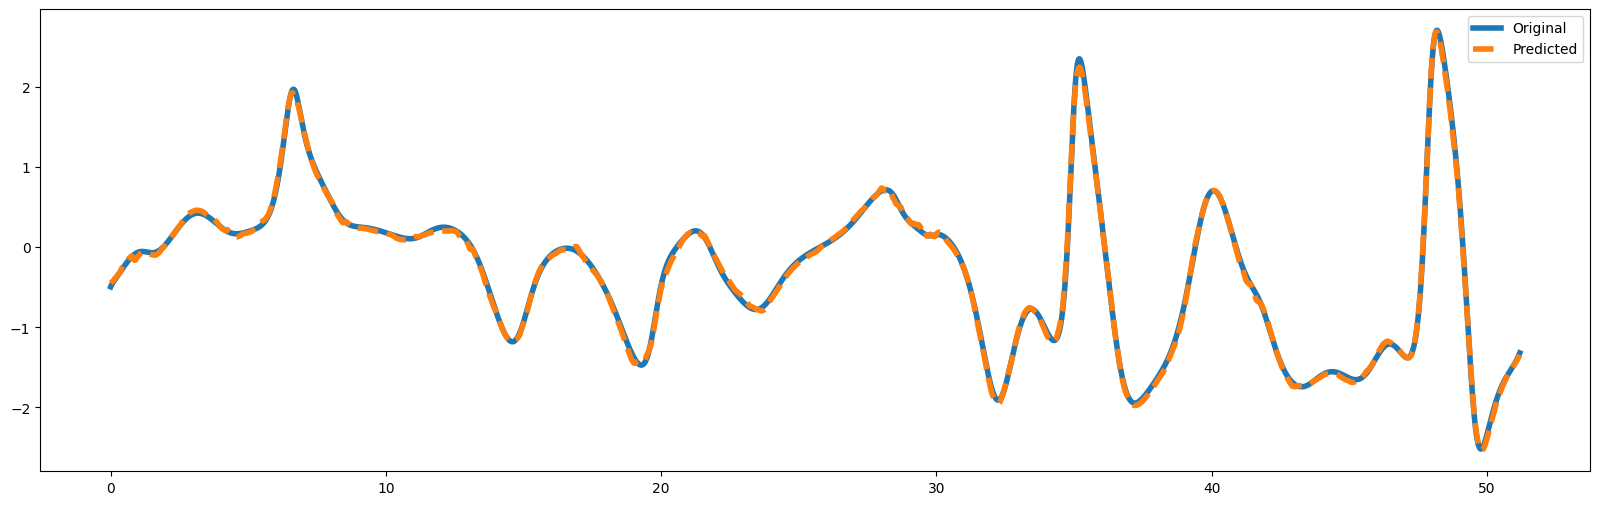

In [15]:
# #plt.figure(size=100)
# fig = plt.figure(figsize=(20, 50))
# plt.imshow(test_data[:,:100].T)
# plt.show()
# fig = plt.figure(figsize=(20, 50))
# plt.imshow(pred[:,:100].T)
# plt.show()
# fig = plt.figure(figsize=(20, 50))
# plt.imshow(np.abs(test_data[:,:100].T-pred[:,:100].T))
# fig.colorbar
# plt.show()
dt=0.01
n_steps=test_dataAE.shape[1]-1
tAE=np.linspace(0,(n_steps-1)*dt, n_steps+1)
fig = plt.figure(figsize=(20, 6))
AE1=test_dataAE[idx,:,0]
AE1_pred=AEpred[idx,:,0]
plt.plot(tAE,AE1,linewidth=4)
#plt.show()
plt.plot(tAE,AE1_pred,'--',linewidth=4)
legend=['Original','Predicted']
plt.legend(legend)
plt.show()

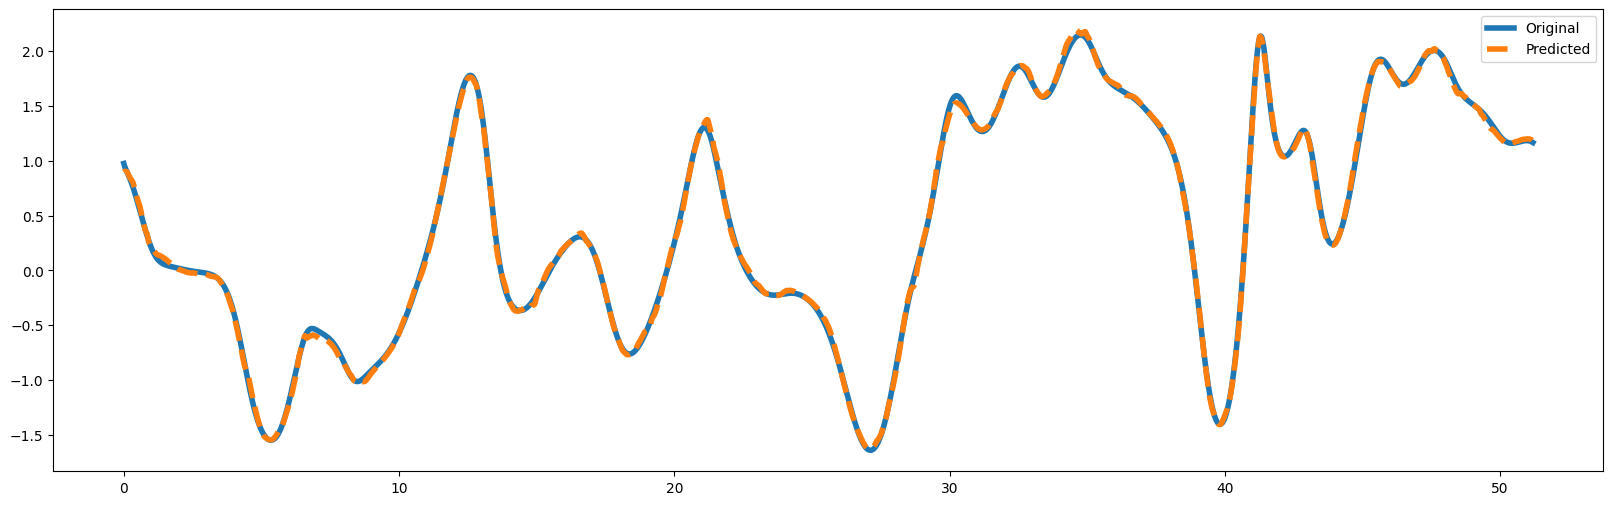

In [16]:
d=50
fig = plt.figure(figsize=(20, 6))
AE2=test_dataAE[idx,:,d]
AE2_pred=AEpred[idx,:,d]
plt.plot(tAE,AE2,linewidth=4)
#plt.show()
plt.plot(tAE,AE2_pred,'--',linewidth=4)
legend=['Original','Predicted']
plt.legend(legend)
plt.show()

In [17]:
from numpy.linalg import norm
from sklearn.metrics import mean_squared_error
autoencoder_output=AEpred
# err=norm(test_dataAE-AEpred)/norm(test_dataAE)
# mse_ae=mean_squared_error(test_dataAE.reshape(test_dataAE.shape[0]*test_dataAE.shape[1],test_dataAE.shape[2])
#      ,autoencoder_output.reshape(autoencoder_output.shape[0]*autoencoder_output.shape[1],autoencoder_output.shape[2]))
#err1=norm(test_data[:100]-pred[:100])/norm(test_data[:100])
#err2=norm(test_data[100:]-pred[100:])/norm(test_data[100:])
mse_ae=criterion(torch.tensor(test_dataAE).float(), torch.tensor(autoencoder_output).float()).mean(-1)
MSE_AE=mse_ae.mean(0)
mse_ae=mse_ae.mean()
mse_ae#,err1,err2

tensor(0.0008)

In [18]:
# plt.plot(mse_ae1.mean(-1))
# plt.show()

In [30]:
# msAE=criterion(torch.tensor(test_dataAE).float(), torch.tensor(autoencoder_output).float()).mean(-1)
#msAE.mean()

In [31]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
# # Plot the first subplot
# im1=axs[0].imshow(test_dataAE[idx,:,:].T, aspect='auto')
# axs[0].set_title('Ground truth')

# # Plot the second subplot
# im2=axs[1].imshow(AEpred[idx,:,:].T, aspect='auto')
# axs[1].set_title('Autoencoder output')

# # Add a title to the entire figure
# fig.suptitle('Comparison between autoencoder output and ground truth')
# fig.colorbar(im1, ax=axs[0])
# fig.colorbar(im2, ax=axs[1])
# # Show the plot
# plt.show()

In [32]:
# fig = plt.figure(figsize=(20, 6))
# plt.imshow(np.abs(test_dataAE[idx,:,:].T-AEpred[idx,:,:].T), aspect='auto')
# cbar = plt.colorbar()
# plt.show()

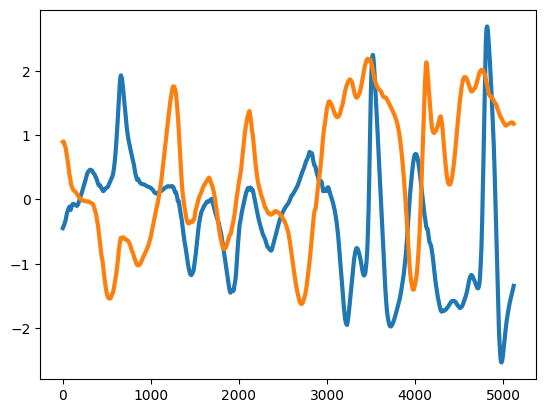

In [19]:
#phase potrait
# plt.plot(AE1[100:], AE2[100:], linewidth=3,label='true')
plt.plot(AE1_pred, linewidth=3,label='true')
plt.plot(AE2_pred, linewidth=3,label='true')
# plt.plot(AE1_pred[100:], AE2_pred[100:], '--',linewidth=3, label='learned')
# plt.legend(loc='lower right')
# plt.xlabel('z1')
# plt.ylabel('z2')
plt.show()

#### Latent dimension 

In [20]:
start=time.time()
z_test=modelAE.encoder(torch.tensor(test_data[:,0,:]).to(torch.float32).to(device))
end=time.time()
AE_time=end-start
AE_time

0.0017008781433105469

In [21]:
#Data for latent dimension
z_train=modelAE.encoder(train_data.to(device))
z_valid=modelAE.encoder(torch.tensor(val_data[:,:,:]).to(torch.float32).to(device))
z_test=modelAE.encoder(torch.tensor(test_data[:,:,:]).to(torch.float32).to(device))
# ####z_valid_scaled=normalize(z_valid)
#####z_test_scaled = normalize(z_test)
z_train.shape,z_valid.shape,z_test.shape

(torch.Size([200, 5121, 8]),
 torch.Size([5, 5121, 8]),
 torch.Size([5, 5121, 8]))

In [22]:
### sAVE FOR MATLAB TEST
# from scipy.io import savemat
# mdic = {"z_train": z_train.cpu().detach().numpy(), "z_valid": z_valid.cpu().detach().numpy(), "z_test": z_test.cpu().detach().numpy()}
# savemat("matlab_latent.mat", mdic)

In [23]:
# from scipy.io import loadmat
# dataa=loadmat("matlab_latent.mat")
# dataa

In [24]:
# z_test=modelAE.encoder(torch.tensor(test_data[:,:,:]).to(torch.float32).to(device))

In [25]:
# z_train=modelAE.encoder(train_data.to(device))

In [26]:
# z_valid=modelAE.encoder(torch.tensor(val_data).to(torch.float32).to(device))

### hits Variables

In [27]:
tspan=z_train.shape[1]
np.random.seed(2)  # for reproduction
dt = 0.01  #0.001
train_steps = tspan  # at least equal to the largest step size
val_steps =tspan
test_steps = tspan  # t=20
t = np.linspace(0, (train_steps-1)*dt, train_steps)

In [28]:
# fig = plt.figure(figsize=(26, 5))
# # plt.imshow(np.abs(test_dataAE[idx,:,:].T-AEpred[idx,:,:].T), aspect='auto')
# # plt.imshow(z_train[1,:,:].T.cpu().detach().numpy(),aspect='auto')
# plt.plot(z_train[1,:,:].cpu().detach().numpy())
# plt.plot(test_data[1,:,:120].cpu().detach().numpy())
# plt.show()

In [29]:
# load the data to dataset object
datasets = list()
step_sizes = list()
print('Dt\'s: ')
#a=[10,20,30,60,100,200,400,600,800]
for i in range(11):
    step_size = 2**i  #exponential function
    print(step_size)
    print(step_size * dt)
    step_sizes.append(step_size)
    datasets.append(DataSet(z_train, z_valid, z_test, dt, step_size=step_size, n_forward=5))

Dt's: 
1
0.01
2
0.02
4
0.04
8
0.08
16
0.16
32
0.32
64
0.64
128
1.28
256
2.56
512
5.12
1024
10.24


#### load RESNET models

In [44]:
model_dir

'../models/FHN'

In [45]:
noise=0.0
models = list() #### FHN Models
for step_size in step_sizes:
    print('loading model_D{}_h{}.pt'.format(step_size,hidden_size))
    models.append(torch.load(os.path.join(model_dir, 'modelFHNtest2_D{}.pt'.format(step_size)))) 

loading model_D1_h2.pt
loading model_D2_h2.pt
loading model_D4_h2.pt
loading model_D8_h2.pt
loading model_D16_h2.pt
loading model_D32_h2.pt
loading model_D64_h2.pt
loading model_D128_h2.pt
loading model_D256_h2.pt
loading model_D512_h2.pt
loading model_D1024_h2.pt


In [34]:
# # # load models on CPU
# models = list()
# for step_size in step_sizes:
#     print('load model_D{}.pt'.format(step_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}.pt'.format(step_size)), map_location='cpu'))

# # fix model consistencies trained on gpus (optional)
# for model in models:
#     model.device = 'cpu'
#     model._modules['increment']._modules['activation'] = torch.nn.ReLU()

In [30]:
### fhn MODELS
# noise=0.0
# models = list() #### FHN Models
# for step_size in step_sizes:
#     print('loading model_D{}_h{}.pt'.format(step_size,hidden_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}_h{}_noise{}.pt'.format(step_size, hidden_size,noise)))) ### Best result so far
noise=0.0
models = list() #### FHN Models
for step_size in step_sizes:
    print('loading model_D{}_h{}.pt'.format(step_size,hidden_size))
    models.append(torch.load(os.path.join(model_dir, 'modelKStest_D{}.pt'.format(step_size)))) 
print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))
#### KS MODELS
# noise=0.0
# models = list()
# for step_size in step_sizes:
#     print('loading model_D{}.pt'.format(step_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}.pt'.format(step_size))))

loading model_D1_h8.pt
loading model_D2_h8.pt
loading model_D4_h8.pt
loading model_D8_h8.pt
loading model_D16_h8.pt
loading model_D32_h8.pt
loading model_D64_h8.pt
loading model_D128_h8.pt
loading model_D256_h8.pt
loading model_D512_h8.pt
loading model_D1024_h8.pt
# of params:  23282776


In [31]:
# 733590/11

In [33]:
#load models
# model_name = 'model_D{}_noise{}.pt'.format(step_size,noise)
# step_sizes=[1,6,36,216,1296]
# noise=0.0
# models = list()
# for step_size in step_sizes:
#     print('loading model_D{}.pt'.format(step_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}.pt'.format(step_size))))
# noise=0.0
# models = list() #### FHN Models
# for step_size in step_sizes:
#     print('loading model_D{}_h{}.pt'.format(step_size,hidden_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}_h{}_noise{}.pt'.format(step_size, hidden_size,noise)))) ### Best result so far FHN

# fix model consistencies trained on gpus (optional)
# for model in models:
#     model.device = 'cpu'
#     model._modules['increment']._modules['activation'] = torch.nn.ReLU()

In [32]:
#Data for latent dimension
# z_train=modelAE.encoder(train_data.to(device))
# z_valid=modelAE.encoder(torch.tensor(val_data).to(torch.float32).to(device))
# z_test=modelAE.encoder(torch.tensor(test_data).to(torch.float32).to(device))
# t_test=T10
# n_steps = t_test    #test_data.shape[1] - 1
# n_steps_val=t_test   #val_data.shape[1] - 1
# z_valid=z_valid[:,:n_steps_val+1,:]
# z_test=z_test[:,:n_steps+1,:]
z_train.shape,z_valid.shape,z_test.shape

(torch.Size([200, 5121, 8]),
 torch.Size([5, 5121, 8]),
 torch.Size([5, 5121, 8]))

In [33]:
# z_test=z_train[:10,:,:]
# t_test=T2

In [34]:
# z_test.shape,z_RN.shape,t_test

In [35]:
test_data.shape[1] - 1

5120

In [36]:
n_steps =test_data.shape[1] - 1   #test_data.shape[1] - 1,t_test
n_steps_val=val_data.shape[1] - 1   #val_data.shape[1] - 1
preds_mse = list()
times = list()
z_hits_uni=[]
print('uniscale forecasting...')
for model in models:
    start = time.time()
    z_RN = model.uni_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps).to(device)
    z_hits_uni.append(z_RN)
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(z_test[:, 1:, :]).float(), z_RN).mean(-1))
print('prediction recorded!')

uniscale forecasting...
prediction recorded!


In [37]:
n_steps_val

5120

In [38]:
times

[0.8736128807067871,
 0.41828417778015137,
 0.21071243286132812,
 0.10593485832214355,
 0.053441762924194336,
 0.027581214904785156,
 0.015239477157592773,
 0.00878763198852539,
 0.021318435668945312,
 0.020499229431152344,
 0.02182745933532715]

In [39]:
#preds_mse[9].mean()
#z_RN.shape
# xyz=preds_mse[0]
# xyz.shape
#xyz.mean()
#z_valid.shape,n_steps

### HITS TESTING

In [40]:
z_valid.shape

torch.Size([5, 5121, 8])

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

use models 4 - 9.
online time elaspsed is 3.2537546157836914


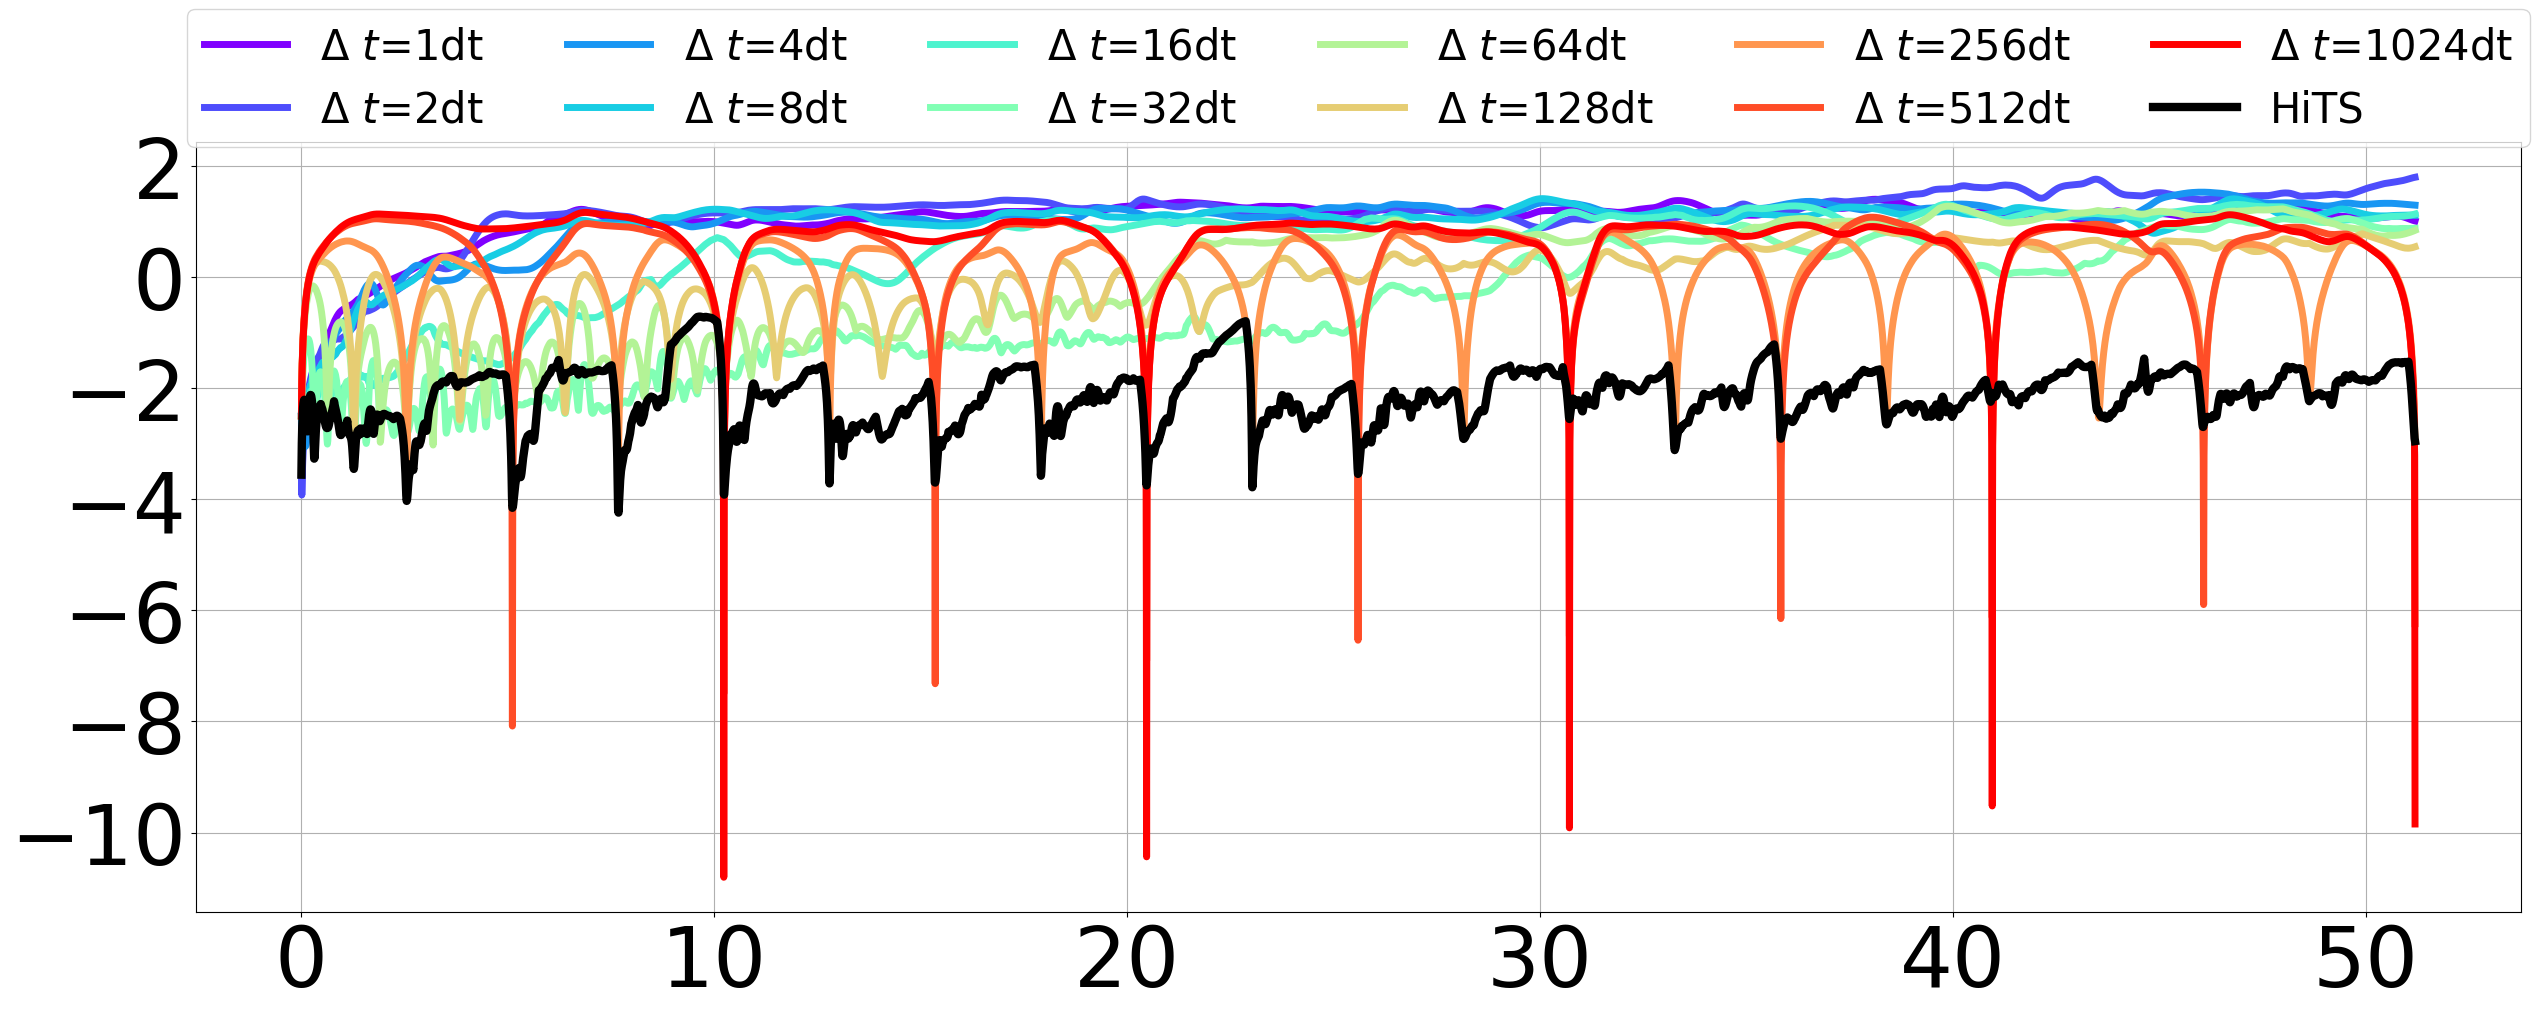

# of params:  23282776


In [41]:
# model selections 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5  #1e+5
start_ttime = time.time()  
# choose the largest time step
for i in tqdm(range(len(models))):
    z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_valid[:, 0, :]).float(), n_steps=n_steps_val, models=models[:len(models)-i]).to(device)
    mse = criterion(torch.tensor(z_valid[:, 1:, :]).float(), z_hits).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

# choose the smallest time step
for i in tqdm(range(end_idx)):
    z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_valid[:, 0, :]).float(), n_steps=n_steps_val, models=models[i:end_idx]).to(device)
    mse = criterion(torch.tensor(z_valid[:, 1:, :]).float(), z_hits).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
     
print('use models {} - {}.'.format(start_idx, end_idx))
models1 = models[start_idx:end_idx]

# models1 = models
# models1=[models[i] for i in [4,5,7,9,10]]
# multiscale time-stepping with NN

z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps, models=models1).to(device)
end_ttime = time.time()
hits_ttime=end_ttime-start_ttime
print('online time elaspsed is',hits_ttime)
multiscale_preds_mse = criterion(torch.tensor(z_test[:, 1:, :]).float(), z_hits).mean(-1)
multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
t = np.linspace(0, (n_steps-1)*dt, n_steps)
# visualize forecasting error at each time step    
norm_uni=list()
nnerr=[]
ks = list(range(11))
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
mean_pointwise=list()
multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
#Figure1: error plot
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).cpu().detach().numpy()
    nnerr.append(mean)
    norm_uni.append(mean.mean())  #mean
    mean_pointwise.append(mean)
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.plot(t, np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid()
plt.show()
print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

In [42]:
z_hits.shape

torch.Size([5, 5120, 8])

In [87]:

# # models1 = models
# # models1=[models[i] for i in [4,5,7,9,10]]
# # multiscale time-stepping with NN
# start_time=time.time()
# z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps, models=models1).to(device)
# end_time = time.time()
# hits_time=end_time-start_time
# print('online time elaspsed is',hits_time)
# multiscale_preds_mse = criterion(torch.tensor(z_test[:, 1:, :]).float(), z_hits).mean(-1)
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# t = np.linspace(0, (n_steps-1)*dt, n_steps)
# # visualize forecasting error at each time step    
# norm_uni=list()
# nnerr=[]
# ks = list(range(11))
# fig = plt.figure(figsize=(30, 10))
# colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
# mean_pointwise=list()
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# #Figure1: error plot
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).cpu().detach().numpy()
#     nnerr.append(mean)
#     norm_uni.append(mean.mean())  #mean
#     mean_pointwise.append(mean)
#     rgb = next(colors)
#     plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
# plt.plot(t, np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
# plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
# plt.xticks(fontsize=60)
# plt.yticks(fontsize=60)
# plt.grid()
# plt.show()

In [49]:
# z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps, models=models1).to(device)
# end_time = time.time()
# hits_time=end_time-start_time
# print('online time elaspsed is',hits_time)
# multiscale_preds_mse = criterion(torch.tensor(z_test[:, 1:, :]).float(), z_hits).mean(-1)
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# t = np.linspace(0, (n_steps-1)*dt, n_steps)
# # visualize forecasting error at each time step    
# norm_uni=list()
# nnerr=[]
# ks = list(range(11))
# fig = plt.figure(figsize=(30, 10))
# colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
# mean_pointwise=list()
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# #Figure1: error plot
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).cpu().detach().numpy()
#     nnerr.append(mean)
#     norm_uni.append(mean.mean())  #mean
#     mean_pointwise.append(mean)
#     rgb = next(colors)
#     plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
# plt.plot(t, np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
# plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
# plt.xticks(fontsize=60)
# plt.yticks(fontsize=60)
# plt.grid()
# plt.show()

In [43]:
print(multiscale_err.mean())

0.014758455


In [44]:
n_steps_val,z_valid.shape

(5120, torch.Size([5, 5121, 8]))

In [45]:
# model selections 
# start_idx = 0
# end_idx = len(models)
# best_mse = 1e+5  #1e+5
# start_time = time.time()
# # choose the largest time step
# for i in tqdm(range(len(models))):
#     z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_valid[:, 0, :]).float(), n_steps=n_steps_val, models=models[:len(models)-i]).to(device)
#     mse = criterion(torch.tensor(z_valid[:, 1:, :]).float(), z_hits).mean().item()
#     if mse <= best_mse:
#         end_idx = len(models)-i
#         best_mse = mse

# # choose the smallest time step
# for i in tqdm(range(end_idx)):
#     z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_valid[:, 0, :]).float(), n_steps=n_steps_val, models=models[i:end_idx]).to(device)
#     mse = criterion(torch.tensor(z_valid[:, 1:, :]).float(), z_hits).mean().item()
#     if mse <= best_mse:
#         start_idx = i
#         best_mse = mse
        
# print('use models {} - {}.'.format(start_idx, end_idx))
# models1 = models[start_idx:end_idx]


# z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps, models=models1).to(device)
# multiscale_preds_mse = criterion(torch.tensor(z_test[:, 1:, :]).float(), z_hits).mean(-1)
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# print(multiscale_err.mean())

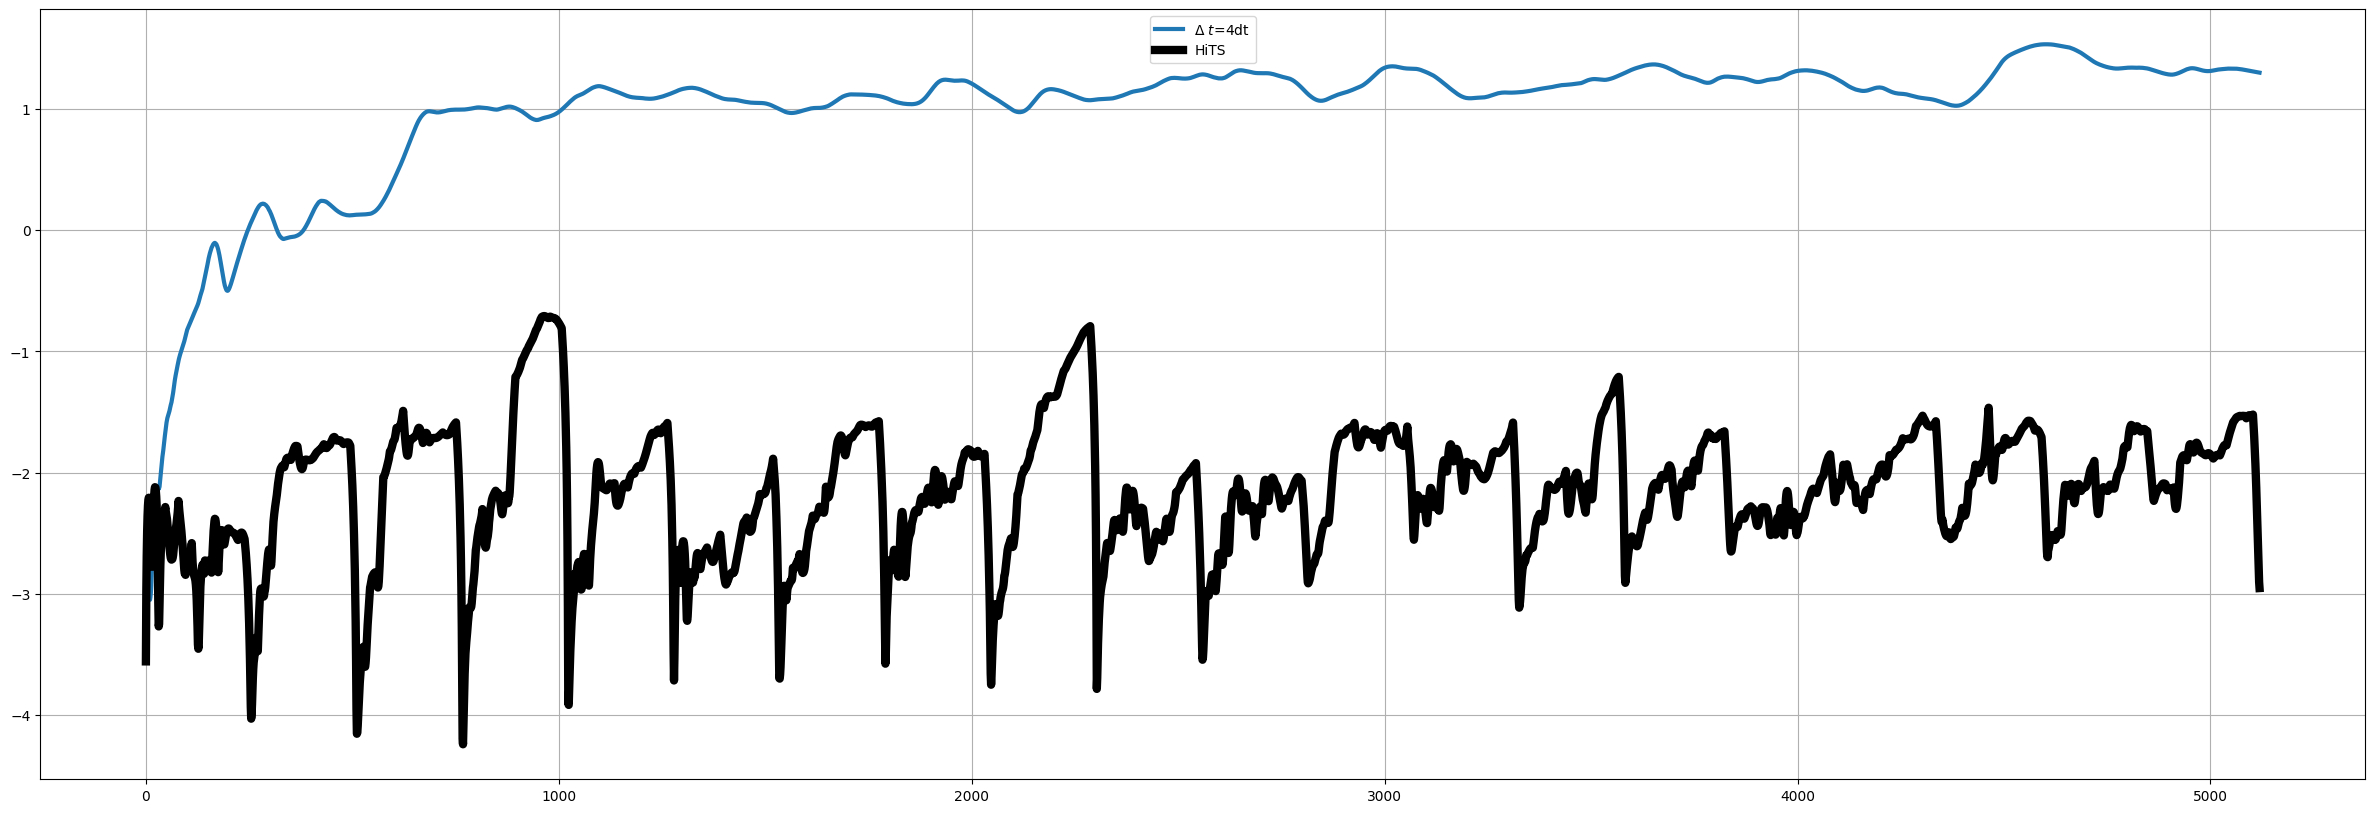

In [46]:
fig = plt.figure(figsize=(30, 10))
for k in range(2,3):
    err = preds_mse[k]
    mean = err.mean(0).cpu().detach().numpy()
    # plt.plot(np.log10(mean), '*', linewidth=3, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    plt.plot(np.log10(mean), linestyle='-', linewidth=3, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.plot(np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
plt.legend(fontsize=10, loc='upper center')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

## hits testng

#### hits TESTING

In [47]:
# plt.plot(MSE_HITS)
# plt.show()

In [48]:
MSE_HITS=multiscale_err
mse_hits=multiscale_err.mean()
print(mse_hits)

0.014758455


In [49]:
###### Normalised test ###########
# (z_test.shape), z_hits.shape
# z_hits_unscale = z_hits * torch.norm(z_test,dim=1,keepdim=True)
# idx=0;
# fig, axs = plt.subplots(1,3,figsize=(15,5))
# ax=axs[0]
# ax.semilogy(multiscale_preds_mse[idx,:300].cpu().detach().numpy(),'k*')
# ax.set_title('Error')
# ax.grid(True)
# ax=axs[1]
# ax.plot(z_test[idx,:1800,1].cpu().detach().numpy(),'*',linewidth=2)
# ax.plot(z_test[idx,:1800,0].cpu().detach().numpy(),'*',linewidth=2)
# # ax.plot(z_hits_unscale[idx,:300,1].cpu().detach().numpy(),'*',linewidth=2)
# ax.set_title('Original')
# ax.grid(True)
# ax=axs[2]
# ax.plot(z_test_scaled[idx,:300,0].cpu().detach().numpy(),'*',linewidth=2)
# ax.plot(z_hits[idx,:300,0].cpu().detach().numpy(),'*',linewidth=2)
# ax.set_title('Normalized')
# ax.grid(True)
# plt.show()

# (z_test_scaled[idx,130,1].cpu().detach().numpy()-z_hits[idx,130,1].cpu().detach().numpy())**2

In [50]:
# norm_uni=list()
# nnerr=[]
# ks = list(range(11))
# fig = plt.figure(figsize=(30, 10))
# colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
# mean_pointwise=list()
# multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
# #Figure1: error plot
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).cpu().detach().numpy()
#     nnerr.append(mean)
#     norm_uni.append(mean.mean())  #mean
#     mean_pointwise.append(mean)
#     rgb = next(colors)
#     plt.plot(t[:-1], np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
# plt.plot(t[:-1], np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
# plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
# plt.xticks(fontsize=60)
# plt.yticks(fontsize=60)
# plt.show()

In [51]:
# mse_hits=multiscale_err.mean()
# print(mse_hits)

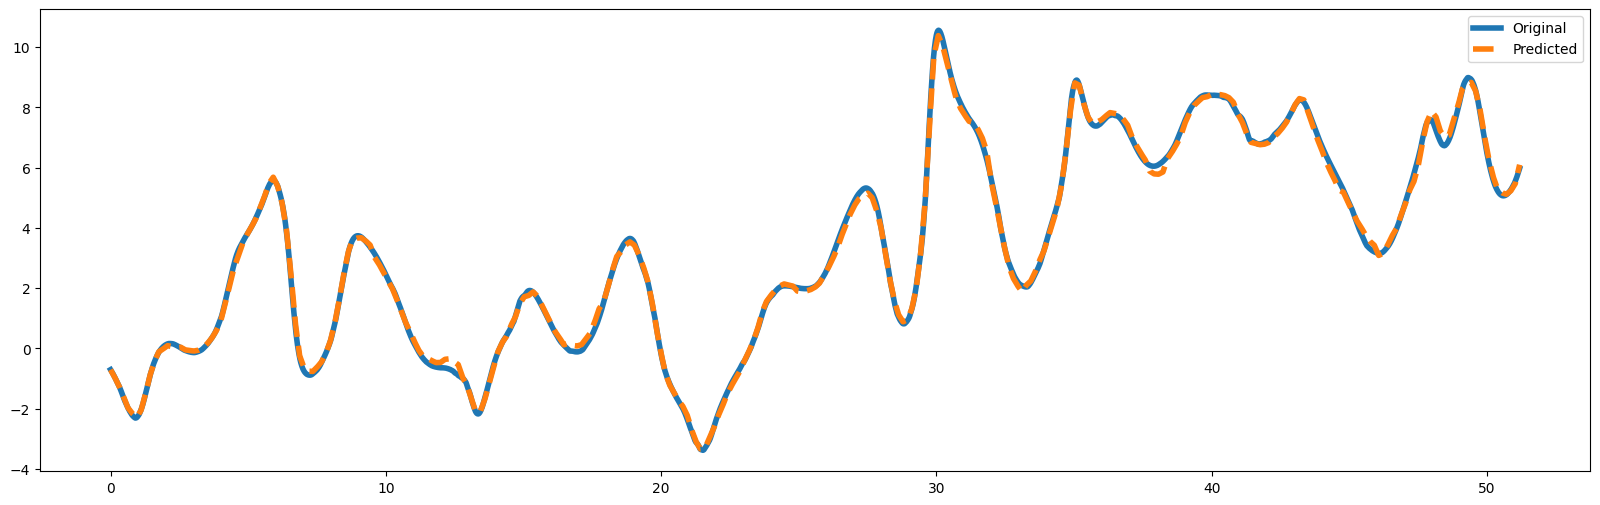

In [52]:
idx=0
z1=0
n_steps=z_test.shape[1]-1
t=np.linspace(0,(n_steps-1)*dt, n_steps)
fig = plt.figure(figsize=(20, 6))
zt=z_test[idx,1:n_steps+1,z1].cpu().detach().numpy()
zhits=z_hits[idx,0:n_steps,z1].cpu().detach().numpy()
plt.plot(t,zt,linewidth=4)
#plt.show()
plt.plot(t,zhits,'--',linewidth=4)
legend=['Original','Predicted']
plt.legend(legend)
plt.show()

In [53]:
idx=0
z1=0
tt=4000
n_steps=z_test.shape[1]-1
t=np.linspace(0,(n_steps-1)*dt, n_steps)
zt=z_test[idx,1:n_steps+1,:].cpu().detach().numpy()
zhits=z_hits[idx,0:n_steps,:].cpu().detach().numpy()
# plt.plot(np.linspace(0,1,n_steps),zt[:,0],zt[:,1],linewidth=3,projection='3d')
# #plt.show()
# # plt.plot(zhits[:,0],zhits[:,1],'--',linewidth=3)
# legend=['Original','Predicted']
# plt.legend(legend)
# plt.show()

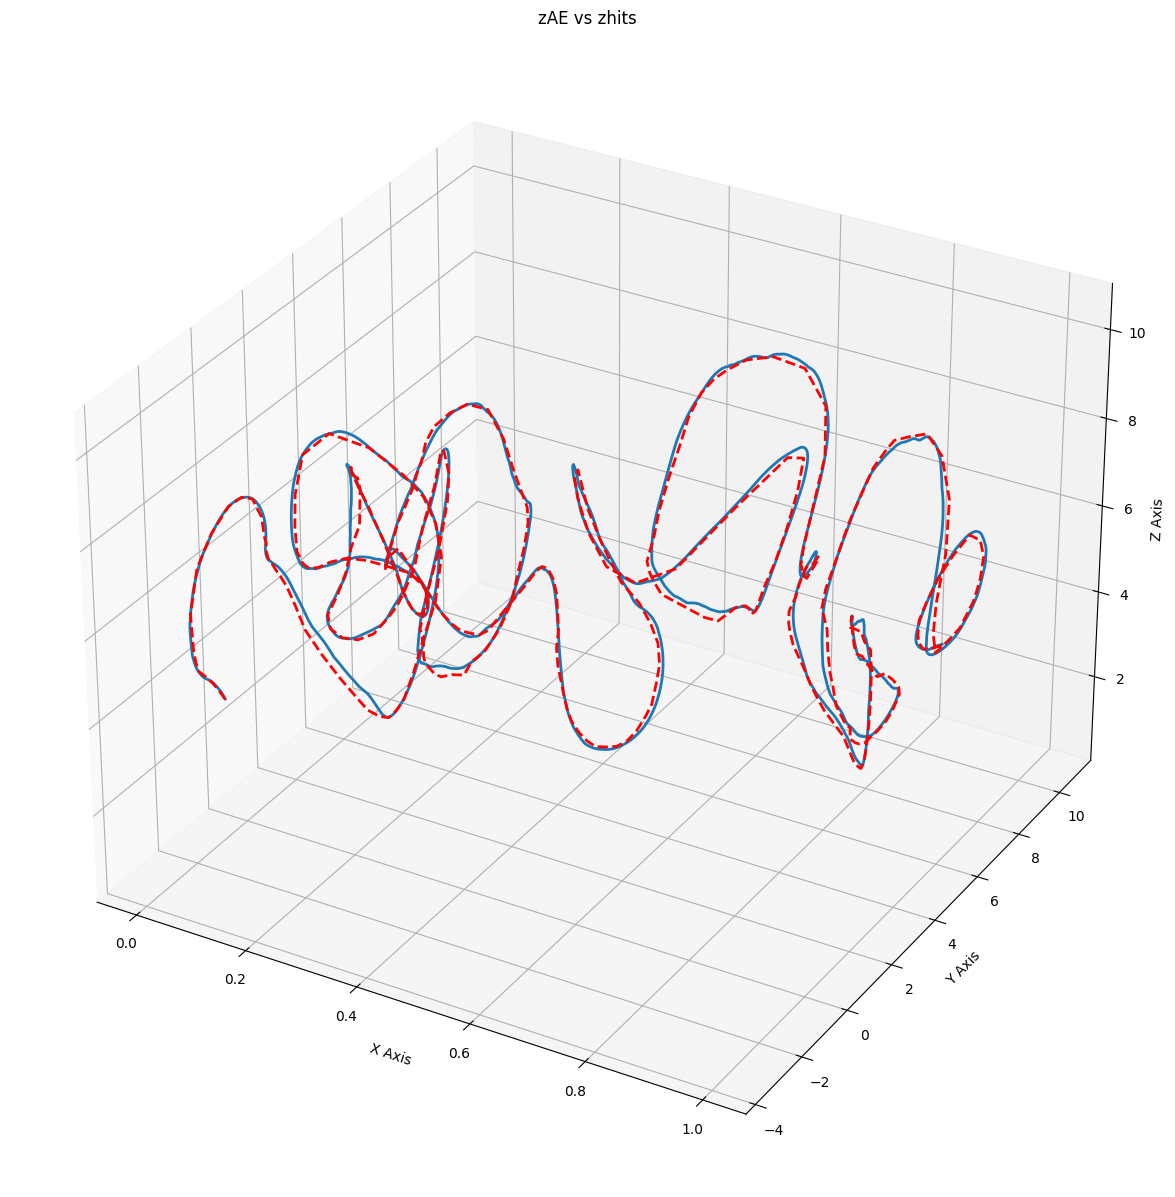

In [54]:
ax = plt.figure(figsize=(80, 15)).add_subplot(projection='3d')

ax.plot(np.linspace(0,1,n_steps),zt[:,0],zt[:,1], lw=2)
ax.plot(np.linspace(0,1,n_steps),zhits[:,0],zhits[:,1],'r--', lw=2)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("zAE vs zhits")

plt.show()

In [55]:
# ax = plt.figure(figsize=(80, 15)).add_subplot(projection='3d')

# ax.plot(np.linspace(0,1,n_steps),zt[:,0],zt[:,1], lw=2)
# ax.plot(np.linspace(0,1,n_steps),zhits[:,0],zhits[:,1],'r--', lw=2)
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("zAE vs zhits")

# plt.show()

In [56]:
# ax = plt.figure(figsize=(80, 15)).add_subplot(projection='3d')

# ax.plot(np.linspace(0,1,n_steps),zt[:,0],zt[:,1], lw=2)
# ax.plot(np.linspace(0,1,n_steps),zhits[:,0],zhits[:,1],'r--', lw=2)
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("zAE vs zhits")

# plt.show()

In [57]:
# from numpy.linalg import norm
# # fig = plt.figure(figsize=(20, 6))
# # error=np.abs(z_test[:,1:,:].cpu().detach().numpy()-z_hits.cpu().detach().numpy())
#err=norm(z_test[:,1:,:].cpu().detach().numpy()-z_hits.cpu().detach().numpy())/norm(z_test[:,1:,:].cpu().detach().numpy())
# print(multiscale_err.mean())
# plt.plot(error)
# plt.show()
#err

In [58]:
# y_hits.shape

In [59]:
startt=time.time()
y_hits=modelAE.decoder(torch.tensor(z_hits).to(device))
endt=time.time()
ytime=endt-startt
aehits_mse=criterion(torch.tensor(test_data[:,1:,:]).to(device).float(), torch.tensor(y_hits).float()).mean(-1)
aehits_mse=aehits_mse.mean()
aehits_mse

tensor(0.0038, device='cuda:0')

In [60]:
ytime,AE_time,hits_ttime

(0.0008287429809570312, 0.0017008781433105469, 3.2537546157836914)

In [61]:
AEhits_time=ytime+AE_time+hits_ttime
print(AEhits_time)

3.256284236907959


In [72]:
# AEhits_timeErr={"aehits_mse":aehits_mse,'AEhits_time':ytime}
# AEhits_timeErr="AEhits_timeErr.pickle"
# with open(path+AEhits_timeErr, "wb") as file:
#     pickle.dump(AEhits_timeErr, file)

In [73]:
# with open("aehits_out", "wb") as fp:
#     pickle.dump(y_hits, fp)

In [74]:
# t_test=t_test+1

In [75]:
# ax = plt.figure(figsize=(80, 15)).add_subplot(projection='3d')
# u=test_data[idx,1:t_test+1,0].cpu().detach().numpy()
# v=test_data[idx,1:t_test+1,50].cpu().detach().numpy()
# uhits=y_hits[idx,:t_test,0].cpu().detach().numpy()
# vhits=y_hits[idx,:t_test,50].cpu().detach().numpy()
# ax.plot(np.linspace(0,1,n_steps),u,v, lw=2)
# ax.plot(np.linspace(0,1,n_steps),uhits,vhits,'r--', lw=2)
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("output aehits Attractor")

# plt.show()

In [76]:
y_hits.shape

torch.Size([1, 5120, 202])

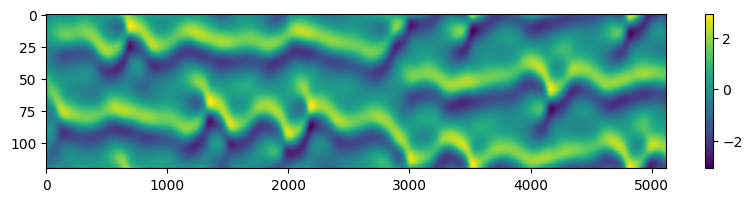

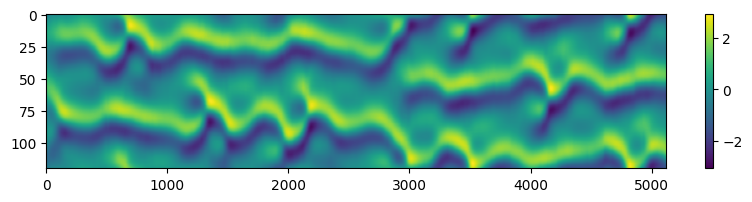

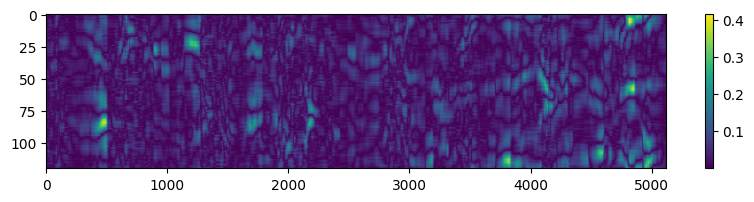

In [62]:
#Final output
idx=0
b=50
yp=y_hits.cpu().detach().numpy()

# err=norm(test_data[:,1:,:]-yp)/norm(test_data[:,1:,:])
# print(err)
fig = plt.figure(figsize=(10, 2))
plt.imshow(test_data[idx,1:,:].T, aspect='auto')
plt.colorbar()
# plt.imshow(test_data[idx,1:T1,:],'k',lw=2)
plt.show()
fig = plt.figure(figsize=(10, 2))
plt.imshow(yp[idx,:,:].T, aspect='auto')
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10, 2))
plt.imshow(np.abs(test_data[idx,1:,:].T-yp[idx,:,:].T), aspect='auto')
plt.colorbar()
plt.show()
# plt.imshow(yp[idx,:,:],'r--',lw=2)
# plt.plot(test_data[:,100:],'k',lw=2)
# plt.plot(pred[:,100:],'r--',lw=2)

In [63]:
#phase potrait
# d=50
# y1_true=test_data[idx,1:T1,0]
# y1_aehits=yp[idx,:,0]
# y2_true=test_data[idx,1:,d]
# y2_aehits=yp[idx,:,d]
# plt.plot(y1_true, y2_true, linewidth=3,label='true')
# plt.plot(y1_aehits, y2_aehits, '--',linewidth=3, label='learned')
# plt.legend(loc='lower left')
# plt.xlabel('y1')
# plt.ylabel('y2')
# plt.show()

In [64]:
#y_preds=AEpreds.cpu()
# z_test=z_test.cpu()
# z_valid=z_valid.cpu()
# z_test.shape

In [65]:
# z_hits=z_hits.to(device)
# z_test=z_test.to(device)
# z_valid=z_valid.to(device)

In [66]:
# idx=10
# n_steps=z_test.shape[1]-1
# t=np.linspace(0,(n_steps-1)*dt, n_steps)
# fig = plt.figure(figsize=(20, 6))
# # y1=test_data[idx,1:,0]
# # y1_pred=y_preds[idx,:,0].detach().numpy()
# plt.plot(t,test_data[idx,1:,1],linewidth=4)
# #plt.show()
# plt.plot(t,y_preds[idx,:,0].detach().numpy(),'--',linewidth=4)
# legend=['Original','Predicted']
# plt.legend(legend)
# plt.show()

In [70]:
# idx=0
# z1=0
# fig = plt.figure(figsize=(20, 6))
# zahits=z_ahits[:,:,:].cpu().detach().numpy()
# plt.plot(z_test[idx,:,z1].cpu().detach().numpy(),linewidth=4)
# #plt.show()
# plt.plot(zahits[idx,:,z1],'--',linewidth=4)
# legend=['Original','Predicted']
# plt.legend(legend)
# plt.show()

In [68]:
# idx=0
# z1=0
# fig = plt.figure(figsize=(20, 6))
# zahits=z_hits[idx,0:n_steps,z1].cpu().detach().numpy()
# plt.plot(t,zt,linewidth=4)
# #plt.show()
# plt.plot(t,zahits,'--',linewidth=4)
# legend=['Original','Predicted']
# plt.legend(legend)
# plt.show()

In [69]:
#print('steps used: {}'.format(steps_used))

In [84]:
print(mse_hits,mse_ahits)

0.0076067066 0.017053194


In [85]:
#print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

In [72]:
# y_ahits=modelAE.decoder(torch.tensor(z_ahits).to(device))
# aeAhits_mse=criterion(torch.tensor(test_data[:,1:T1,:]).to(device).float(), torch.tensor(y_ahits[:,1:,:]).float()).mean(-1)
# aeAhits_mse=aeAhits_mse.mean()
# print(aeAhits_mse)

In [58]:
y_ahits.shape,test_data.shape

(torch.Size([10, 5121, 100]), torch.Size([10, 51200, 100]))

In [74]:
# #Final output
# idx=0
# b=50
# ypa=y_ahits.cpu().detach().numpy()

# # err=norm(test_data[:,1:,:]-yp)/norm(test_data[:,1:,:])
# # print(err)
# plt.plot(test_data[idx,1:T1,b],'k',lw=2)
# plt.plot(ypa[idx,1:n_steps+1,b],'r--',lw=2)
# # plt.plot(test_data[:,100:],'k',lw=2)
# # plt.plot(pred[:,100:],'r--',lw=2)
# plt.show()

In [75]:
# #phase potrait
# d=50
# y1_true=test_data[idx,1:,0]
# y1_aeAhits=ypa[idx,1:n_steps+1,0]
# y2_true=test_data[idx,1:,d]
# y2_aeAhits=ypa[idx,1:n_steps+1,d]
# plt.plot(y1_true, y2_true, linewidth=3,label='true')
# plt.plot(y1_aeAhits, y2_aeAhits, '--',linewidth=3, label='learned')
# plt.legend(loc='lower left')
# plt.xlabel('y1')
# plt.ylabel('y2')
# plt.show()

### SAVE Results

In [76]:
encoded.shape,z_hits.shape

(torch.Size([5, 5121, 8]), torch.Size([5, 5120, 8]))

In [77]:
AEpred.shape,y_hits.shape

((5, 5121, 120), torch.Size([5, 5120, 120]))

In [78]:
path

'../aehitsResults/KS/data/KS'

In [82]:
# times_error={"error_ind":preds_mse,'cpu_times':times}
# times_errorfile="times_error.pickle"
# with open(path+times_errorfile, "wb") as file:
#     pickle.dump(times_error, file)

In [84]:
# GPUtimes = {"hits_time":AE_time+hits_ttime}
# filename="GPUtimes.pickle"
# with open(path+filename, "wb") as file:
#     pickle.dump(GPUtimes, file)

In [85]:
# mse = {"aehits_mse":aehits_mse,"aelstm_mse": aelstm_mse,"aeRC_mse": aeRC_mse,"aesindy_mse": aesindy_mse}
# filename="mse.pickle"
# with open(path+filename, "wb") as file:
#     pickle.dump(mse, file)

In [79]:
test_data.shape,encoded.shape,z_hits.shape

(torch.Size([5, 5121, 120]),
 torch.Size([5, 5121, 8]),
 torch.Size([5, 5120, 8]))

In [80]:
path

'../aehitsResults/KS/data/KS'

In [82]:
results = {"test_data":test_data,"encoded": encoded,"z_hits": z_hits,"AEpred": AEpred,"y_hits": y_hits,"NNTS_error":preds_mse,'multiscale_err':multiscale_err}
filename="results.pickle"
with open(path+filename, "wb") as file:
    pickle.dump(results, file)

In [293]:
# file="test_data.pickle"
# with open(path+file, "wb") as file:
#     pickle.dump(test_data, file)

In [294]:
path

'../results/FHN/data/FHN'

### save MSE results as table

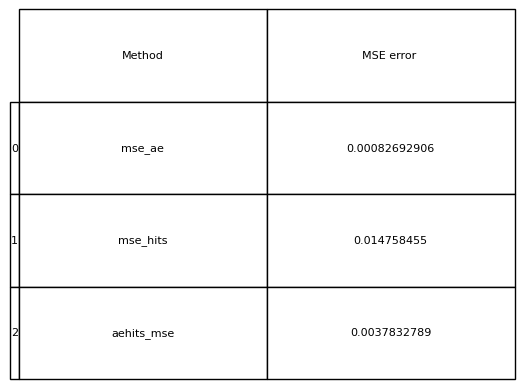

In [83]:
import pandas as pd
# Create a dictionary with variable names as keys and values as entries
datatable = {
    'Method': ['mse_ae', 'mse_hits', 'aehits_mse'],
    'MSE error ': [mse_ae.cpu().detach().numpy(), mse_hits, aehits_mse.cpu().detach().numpy()]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(datatable)

# Create a table plot using pandas
table = pd.plotting.table(
    ax=plt.gca(),
    data=df,
    loc='center',
    cellLoc='center',
    colWidths=[0.2, 0.2],
    bbox=[0, 0, 1, 1]
)

# Customize the table appearance
table.set_fontsize(14)
table.scale(1.2, 1.2)

# Remove the axis labels and ticks
plt.axis('off')

# Save the figure
tablename='mse_table.png'
plt.savefig(path+tablename, bbox_inches='tight')


### save computational time results as table

In [104]:
# import pandas as pd
# # Create a dictionary with variable names as keys and values as entries
# datatable = {
#     'Method': ['HiTS', 'LSTM', 'RC','SINDY'],
#     'Computational Time ': [hits_ttime,lstm_time,rc_time,sindy_time]
# }

# # Create a DataFrame from the dictionary
# df = pd.DataFrame(datatable)

# # Create a table plot using pandas
# table = pd.plotting.table(
#     ax=plt.gca(),
#     data=df,
#     loc='center',
#     cellLoc='center',
#     colWidths=[0.2, 0.2],
#     bbox=[0, 0, 1, 1]
# )

# # Customize the table appearance
# table.set_fontsize(14)
# table.scale(1.2, 1.2)

# # Remove the axis labels and ticks
# plt.axis('off')

# # Save the figure
# tablename='cputime_table_5T.png'
# plt.savefig(path+tablename, bbox_inches='tight')
